
<div>
    <h1 style="margin-top: 50px; font-size: 33px; text-align: center">Fundalmental of Data Science - Final Project</h1>
    <br>
    <div style="font-weight:200; font-size: 30px; padding-bottom: 15px; width: 100%; text-align: center;">
        <right>Kaggle Competition House Prices: Advanced Regression Techniques</right>
        <br>
        <div style="font-weight:200; font-size: 20px; padding-bottom: 20px; width: 100%; text-align: center;">
        <right>Valerio Antonini (1611556), Maria Luisa Croci (1597797), Daniele Sanna (1257436)</right>
    </div>
    <hr>
</div>

The goal of the following project is to predict the sales prices of the houses in Ames (Iowa) using advanced regression rechniques as Lasso and XGBoost.

### Import libraries

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from sklearn.linear_model import ElasticNet, Lasso, LassoCV, BayesianRidge ,  ElasticNetCV
from sklearn.linear_model import Ridge , RidgeCV
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import RegressorMixin
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
import xgboost as xgb

# 1) Exploring data and missing value

### Load data sets

In [2]:
train = pd.read_csv(r"C:\Users\Daniele\Desktop\Bressan\train.csv")
test = pd.read_csv(r"C:\Users\Daniele\Desktop\Bressan\test.csv")

In [3]:
#save the Id for submission dataset 
test_ID = test['Id']

#drop Id columns, we don't need them for the prediction
train=train.drop(['Id'],axis=1)
test=test.drop(['Id'],axis=1)

### Look at the distribution of Sale Price

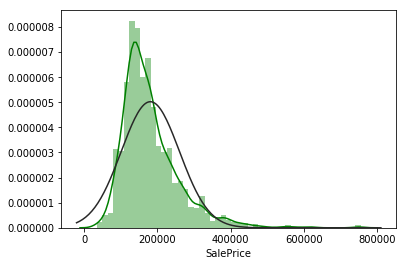

In [4]:
sns.distplot(train['SalePrice'] ,fit=norm,color="g",hist=True)

In [5]:
(mu, sigma) = norm.fit(train['SalePrice'])
print("mean = ", mu, " variance = ", sigma)

mean =  180921.19589041095  variance =  79415.29188606751


### Apply logarithm to normalize the distribution


In [6]:
train['SalePrice'] = np.log1p(train['SalePrice'])
(mu, sigma) = norm.fit(train['SalePrice'])
print("mean = ", mu, " variance = ", sigma)

mean =  12.024057394918406  variance =  0.39931245219387496


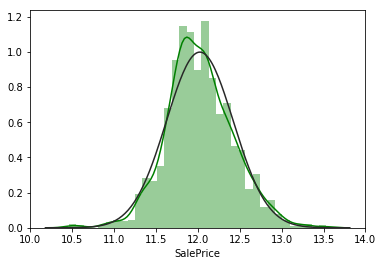

In [7]:
sns.distplot(train['SalePrice'] ,fit=norm,color="g",hist=True)

### Remove outliers looking at the linear relationship between a feature and Sale Price

In [ ]:
##nb we don't run this chunk in order to have a smaller size of this file

fig = plt.figure(figsize=(10,120))

ax1 = fig.add_subplot(35,1,1)
ax2 = fig.add_subplot(35,1,2)
ax3= fig.add_subplot(35,1,3)
ax4= fig.add_subplot(35,1,4)
ax5= fig.add_subplot(35,1,5)
ax6= fig.add_subplot(35,1,6)

#MasVnrArea: Masonry veneer area in square feet
sns.regplot(x='MasVnrArea', y='SalePrice', data=train, ax=ax1,fit_reg=False)
#BsmtFinSF1: Type 1 finished square feet
sns.regplot(x='BsmtFinSF1', y='SalePrice', data=train, ax=ax2,fit_reg=False)
#TotalBsmtSF: Total square feet of basement area
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=train, ax=ax3,fit_reg=False)
#1stFlrSF: First Floor square feet
sns.regplot(x='1stFlrSF', y='SalePrice', data=train, ax=ax4,fit_reg=False)
#GarageArea: Size of garage in square feet
sns.regplot(x='GarageArea', y='SalePrice', data=train, ax=ax5,fit_reg=False)
#GrLivArea: Above grade (ground) living area square feet
sns.regplot(x='GrLivArea', y='SalePrice', data=train, ax=ax6,fit_reg=False)

In [9]:
#outliers removal MasVnrArea
train=train[(train.MasVnrArea<1500)]
#outlier removal BsmtFinSF1
train=train[(train.BsmtFinSF1<2800)]
#outlier removal TotalBsmtSF
train=train[(train.TotalBsmtSF<3500)]
#outlier removal 1stFlrSF
train=train[(train['1stFlrSF']<3500)]
#outlier removal GarageArea
train=train[(train.GarageArea<1200)]
#outlier removal GrLivArea
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

### Look at the correlations

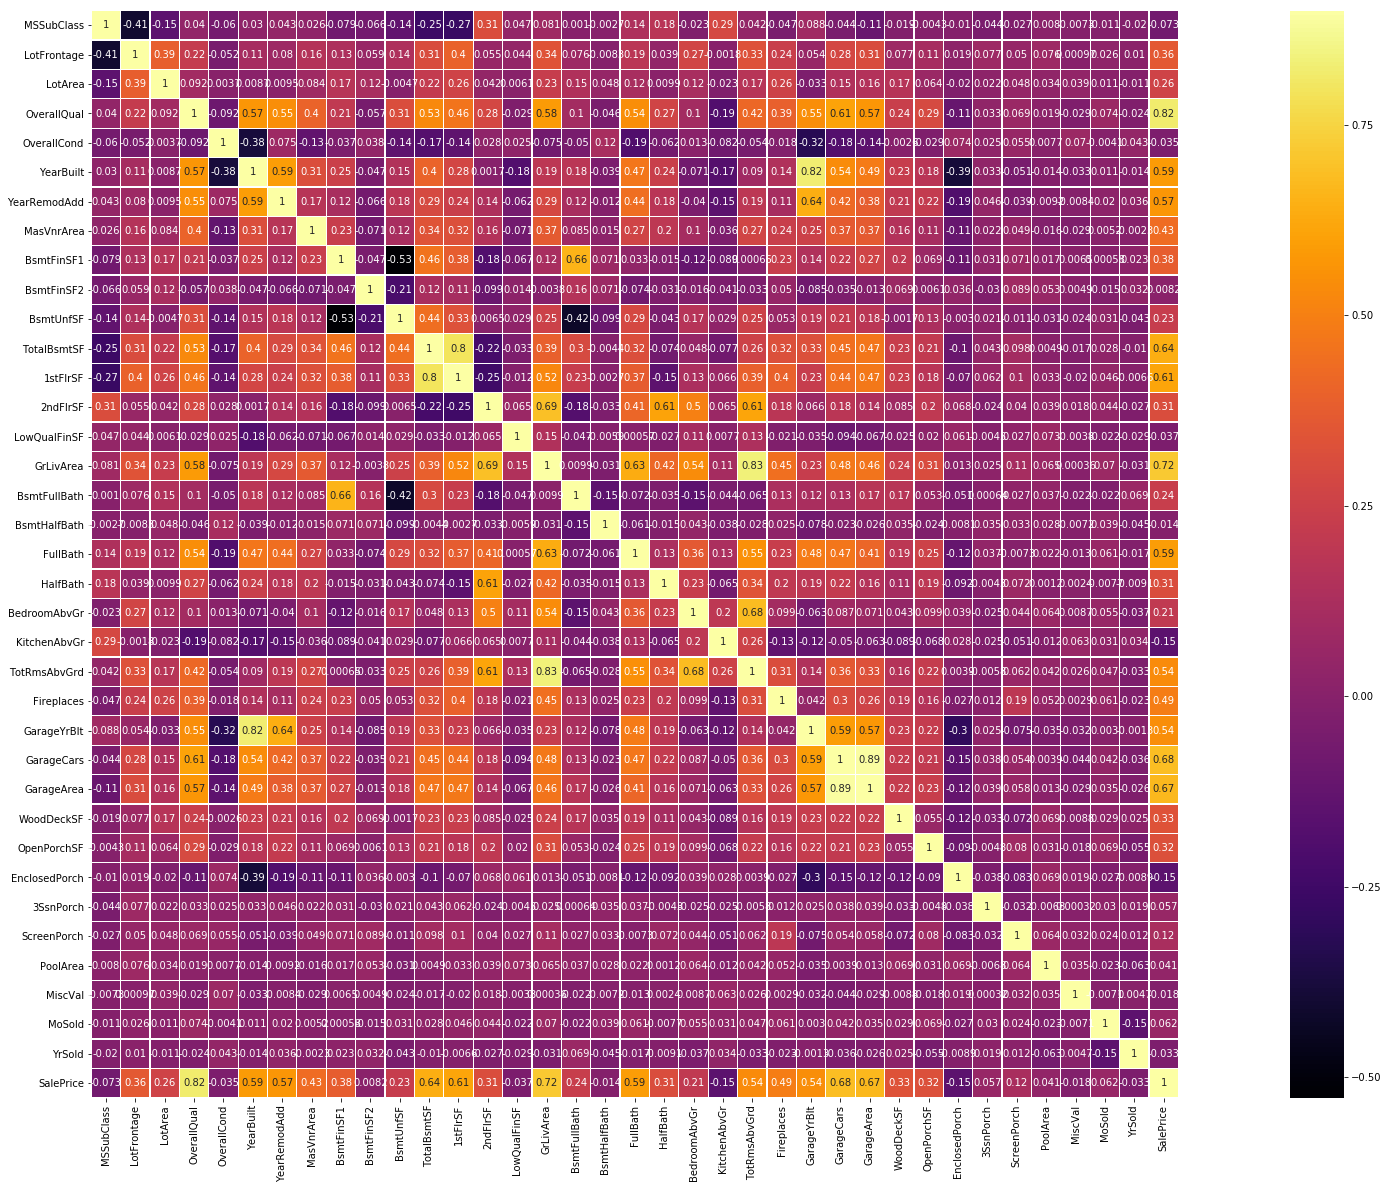

In [10]:
corrmap = train.corr()
plt.subplots(figsize=(40,20))
sns.heatmap(corrmap, vmax=0.9, square=True, annot=True,linewidths=.2,cmap='inferno')

In [11]:
ntrain = train.shape[0] 
#ntest = test.shape[0]
y_train = train.SalePrice.values #save the prices



### Merge test and train

In [12]:
Union_data = pd.concat((train, test)).reset_index(drop=True)
Union_data.drop(['SalePrice'], axis=1, inplace=True) #Drop the sale price, we don't need them for the prediction

#check the Union_data size
print(Union_data.shape)

(2902, 79)


C:\Users\Daniele\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Define a function in order to have a better visualization for the missing data

In [13]:
#check missing vaue
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [14]:
missing_values_table(Union_data).head(10)

Your selected dataframe has 79 columns.
There are 34 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,2894,99.7
MiscFeature,2798,96.4
Alley,2706,93.2
Fence,2332,80.4
FireplaceQu,1415,48.8
LotFrontage,483,16.6
GarageCond,159,5.5
GarageQual,159,5.5
GarageYrBlt,159,5.5
GarageFinish,159,5.5


### Define function for cleaning according to *summary.pdf*

In [15]:
def clean(Union_data):
    
    #transform numerical in categorical
    Union_data['MoSold'] = Union_data['MoSold'].astype(str)
    Union_data['YrSold'] = Union_data['YrSold'].astype(str)
    Union_data['MSSubClass'] = Union_data['MSSubClass'].astype(str)
    Union_data['OverallQual'] = Union_data['OverallQual'].astype(str)
    
    
    #add new usefull variable
    Union_data['TotalSF']=Union_data['TotalBsmtSF'] + Union_data['GrLivArea']
    
    
    #fill "NA" with "None"
    
    Union_data['Alley']=Union_data['Alley'].fillna('None')
    Union_data['GarageQual']=Union_data['GarageQual'].fillna('None')
    Union_data['GarageFinish']=Union_data['GarageFinish'].fillna('None')
    Union_data['GarageCond']=Union_data['GarageCond'].fillna('None')
    Union_data['GarageType']=Union_data['GarageType'].fillna('None')
    Union_data['BsmtCond']=Union_data['BsmtCond'].fillna('None')
    Union_data['BsmtExposure']=Union_data['BsmtExposure'].fillna('None')
    Union_data['BsmtQual']=Union_data['BsmtQual'].fillna('None')
    Union_data['BsmtFinType2']=Union_data['BsmtFinType2'].fillna('None')
    Union_data['BsmtFinType1']=Union_data['BsmtFinType1'].fillna('None')
    Union_data['MasVnrType']=Union_data['MasVnrType'].fillna('None')
    
    
    #fill "NA" with mode/median/0
    
    Union_data['LotFrontage']=Union_data['LotFrontage'].fillna(Union_data['LotFrontage'].median())
    Union_data['Functional']=Union_data['Functional'].fillna(Union_data['Functional'].mode()[0])
    Union_data['GarageCars'] = Union_data['GarageCars'].fillna(Union_data['GarageCars'].mode()[0])
    Union_data['Exterior2nd']=Union_data['Exterior2nd'].fillna(Union_data['Exterior2nd'].mode()[0])
    Union_data['Exterior1st']=Union_data['Exterior1st'].fillna(Union_data['Exterior1st'].mode()[0])
    Union_data['Electrical']=Union_data['Electrical'].fillna(Union_data['Electrical'].mode()[0])
    Union_data['KitchenQual']=Union_data['KitchenQual'].fillna(Union_data['KitchenQual'].mode()[0])
    Union_data['SaleType']=Union_data['SaleType'].fillna(Union_data['SaleType'].mode()[0])
    Union_data['BsmtFullBath'] = Union_data['BsmtFullBath'].fillna(0)
    Union_data['BsmtHalfBath'] = Union_data['BsmtHalfBath'].fillna(0)
    Union_data['BsmtFinSF1'] = Union_data['BsmtFinSF1'].fillna(0)
    Union_data['BsmtFinSF2'] = Union_data['BsmtFinSF2'].fillna(0)
    Union_data['BsmtUnfSF'] = Union_data['BsmtUnfSF'].fillna(0)
    Union_data['TotalBsmtSF'] = Union_data['TotalBsmtSF'].fillna(0)
    Union_data['TotalSF'] = Union_data['TotalSF'].fillna(0)
    Union_data['GarageYrBlt']=Union_data['GarageYrBlt'].fillna(0)

    #drop columns 
    
    Union_data.drop('MSZoning',axis=1,inplace=True)
    Union_data.drop('Utilities',axis=1,inplace=True)
    Union_data.drop('FireplaceQu',axis=1,inplace=True) #High percentage of Na values
    Union_data.drop('PoolArea',axis=1,inplace=True)
    Union_data.drop('PoolQC',axis=1,inplace=True) #High percentage of Na values
    Union_data.drop('Fence',axis=1,inplace=True) #High percentage of Na values
    Union_data.drop('MiscFeature',axis=1,inplace=True)
    Union_data.drop('MiscVal',axis=1,inplace=True)
    Union_data.drop('GarageArea',axis=1,inplace=True)
    Union_data.drop('TotalBsmtSF',axis=1,inplace=True) #remove it because used to create TotalSf
    Union_data.drop('GrLivArea',axis=1,inplace=True) #remove it because used to create TotalSf
    Union_data.drop('LotFrontage',axis=1,inplace=True)
    Union_data.drop('YearRemodAdd',axis=1,inplace=True)
    Union_data.drop('MasVnrArea',axis=1,inplace=True)
    Union_data.drop('KitchenAbvGr',axis=1,inplace=True)
    Union_data.drop('OpenPorchSF',axis=1,inplace=True)
    Union_data.drop('LotConfig',axis=1,inplace=True)
    Union_data.drop('LotShape',axis=1,inplace=True)

    return Union_data

In [16]:
Union_data = clean(Union_data)

### Check again if there are still missing values

In [17]:
missing_values_table(Union_data)

Your selected dataframe has 62 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Get dummies for categorical features

In [18]:
Union_data = pd.get_dummies(Union_data)
print(Union_data.shape)

(2902, 295)


### Split *Union_data* in order to have again *train* and *test* 

In [19]:
train = Union_data[:ntrain]
test = Union_data[ntrain:]

# 2) Modelization

In [20]:
### Look up the best models 

In [21]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=5))
    return rmse

models = [Ridge(),
             Lasso(alpha=0.0005,max_iter=50000,random_state=0),
             RandomForestRegressor(),
             GradientBoostingRegressor(),
             SVR(),
             ElasticNet(alpha = 0.0005,max_iter=10000),
             linear_model.SGDRegressor(max_iter=1000, tol = 1e-3),
             BayesianRidge(),
             lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11),

            xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.2999,
                 reg_lambda=0.6, 
                 subsample=0.2,
                 seed=42,
                 silent=1)]

names = ['Ridge','Lasso','RF','GBR','SVR','ENet','SGDR','BayRidge','LGB','XGBR']

In [22]:
for model,name in zip(models,names):
    score = rmse_cv(model,train,y_train)
    print("{}: {:.6f}, {:4f}".format(name,score.mean(),score.std()))

Ridge: 0.124465, 0.005673


C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

Lasso: 0.117154, 0.006054
RF: 0.145588, 0.006955
GBR: 0.127681, 0.007389
SVR: 0.393321, 0.016219


C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Daniele\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

ENet: 0.118264, 0.006146
SGDR: 99207289026745216.000000, 47136396609693088.000000
BayRidge: 0.118775, 0.005722
LGB: 0.117169, 0.006181
XGBR: 0.116287, 0.005580


In [23]:
scaler = RobustScaler()
train = scaler.fit(train).transform(train)
test = scaler.transform(test)

### Lasso

In [24]:
lasso = Lasso(alpha=0.00009, max_iter=50000, random_state=0)
lasso.fit(train, y_train)
lasso_preds = lasso.predict(test)


### XGBoost

In [25]:
#regr

xgboost = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.2999,
                 reg_lambda=0.6, 
                 subsample=0.2,
                 seed=42,
                 silent=1)

xgboost.fit(train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.0, learning_rate=0.01,
       max_delta_step=0, max_depth=6, min_child_weight=1.5, missing=None,
       n_estimators=7200, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.2999, reg_lambda=0.6,
       scale_pos_weight=1, seed=42, silent=1, subsample=0.2)

### Elastic Net

In [26]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00008, l1_ratio=.8, random_state=3,max_iter=100000))
ENet.fit(train, y_train)
en_preds = ENet.predict(test)


### LGBMRegressor

In [27]:
lgb_model = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=800,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

lgb_model.fit(train, y_train)
lgbm_preds = lgb_model.predict(test)


### Use Stacking

In [28]:
lasso_model = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = [0.0004, 0.0005, 0.0006],
                              random_state = 0, cv=5))

elasticnet_model = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=[0.0005], 
                                        cv=5, l1_ratio=0.9,random_state = 0))

ridge_model = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = [14.99], cv=5))

In [29]:
ridge_model.fit(train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridgecv', RidgeCV(alphas=[14.99], cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False))])

In [30]:
stack_regressor = StackingCVRegressor(regressors=(lasso_model, elasticnet_model, xgboost, ridge_model), 
                               meta_regressor=xgboost, use_features_in_secondary=True)

In [31]:
print("The following code require few minutes to complete. Please wait...")
stack_model = stack_regressor.fit(train,y_train)
print("Done!")

The following code require few minutes to complete. Please wait...
Done!


### Combine stacking and other models using average weighted 

In [32]:
stack_gen_preds = stack_model.predict(test)
stack_preds = ((0.4*lasso_preds) + (0.5*stack_gen_preds) + (0.05*en_preds)+ (0.05*lgbm_preds))  

### Save prediction and create data frame for submission

In [34]:
y_pred = np.expm1(stack_preds)
submit = pd.DataFrame()
submit['Id']=test_ID
submit['SalePrice']=y_pred
submit.to_csv('submit.csv', index=False)

In [41]:
submit.head(10)

,Id,SalePrice
0,1461,121151.407213
1,1462,160351.424504
2,1463,186482.185929
3,1464,199425.875508
4,1465,190829.881198
5,1466,171061.837702
6,1467,177815.530868
7,1468,170533.103853
8,1469,188295.525906
9,1470,122288.417939
